In [1]:
import numpy as np
import pandas as pd
import AgentClass
import const
import random
import networkx as nx
import os, shutil

from scipy import stats
import utilities

%matplotlib inline
import seaborn as sns
from random import shuffle
import analysis as az


sns.set(style='darkgrid', rc={'figure.figsize':(10,6)}, font_scale=1.25)


num_agents = 1024
number_of_bits = 10

def get_tau_distr():
    lower = 0
    upper = 1
    mu = 0.5
    sigma = 0.1
    N = num_agents

    samples = stats.truncnorm.rvs(
          (lower-mu)/sigma,(upper-mu)/sigma,loc=mu,scale=sigma,size=N)

    return samples

def create_even_bits_init_states():
    eq_bits = [[0 for i in range(num_agents//2)] + [1 for i in range(num_agents//2)] for i in range(number_of_bits)]
    for i in eq_bits:
        shuffle(i)
    return [[bit.pop() for bit in eq_bits] for i in range(num_agents)]  


def binary_rep(n):
    fmt = '{0:0'+str(number_of_bits)+'b}'
    return [[int(i) for i in fmt.format(x)] for x in n]
  
def create_environment(inital_states):
    list_agents = []
    tau_distr = get_tau_distr()
    for i in range(num_agents):
        in_state = inital_states.pop()
        a = AgentClass.Agent(name='agent{}'.format(i), tau=random.choice(tau_distr), initial_state=in_state)
        list_agents.append(a)

    # create network
    G = nx.barabasi_albert_graph(num_agents, 2, seed= 0)
    df = nx.to_pandas_adjacency(G, dtype=int)

    tmp_edges = df.apply(lambda row: row.to_numpy().nonzero()).to_dict()
    edges = {k: v[0].tolist() for k, v in tmp_edges.items()}

    # make random connections with agents
    for k, v in edges.items():
        for ngh in v:
            list_agents[k].add_neighbors(list_agents[ngh])

    return list_agents

def reinit_agents(agents,initial_states):
    copy = []+initial_states
    for a in agents:
        if len(initial_states)==0:
            print("Recycling state vector")
            initial_states = []+copy
        a.reset_state(initial_states.pop())

def get_network_df(list_agents):
    network_df = pd.DataFrame({'source':[], 'target':[]})
    for agt in list_agents:
        neighbors = agt.get_neighbors_name()
        for n in neighbors:
            network_df = network_df.append({'source':agt.name,
                                        'target':n}, ignore_index=True)
    return network_df

def run_simulation(alpha, coherence, bit_mat, list_agents, end_time, exp):
    d = []
    generations = 0
    for t in range(end_time):
        # compute next state for all agents
        for agt in list_agents:
            agt.update_knowledge(alpha, coherence, bit_mat)

        # keep record of current record and all other values
        for agt in list_agents:
            row = {'Agent_Number': int(agt.name.split('t')[1]),
                   'Time':t,
                   # at any time step we will need normalized how many neighbors disagree on bits
                   'bits_disagreement':np.mean(agt.state_disagreements),
                   #'Current_Knowledge_State':agt.knowledge_state,
                   'Current': utilities.bool2int(agt.knowledge_state),
                   'alpha':alpha,
                   'Next': utilities.bool2int(agt.next_state),
                   #'Next_Knowledge_State':agt.next_state,
                   "Experiment":exp}

            d.append(row)

        # now update all agents next state with computed next state
        for agt in list_agents:
            agt.knowledge_state = agt.next_state
            agt.next_state = None
            agt.dissonance_lst = None

        generations+=1

    return pd.DataFrame(d)


def create_graph_from_records(records:pd.DataFrame, remove_self_loops = True):
    records["weight"] = 1
    x=records[["Current","Next","weight"]].groupby(["Current","Next"]).agg('count').reset_index()
    if remove_self_loops:
        x.drop(x[x.Current == x.Next].index, inplace=True)
    xg = nx.from_pandas_edgelist(x,"Current","Next","weight",create_using = nx.MultiDiGraph)
    return xg


def save_experiment(sim,config,results_df:pd.DataFrame,network_df:pd.DataFrame,name="empirical_data"):
    path = "../simulations/s{}".format(sim)
    if not os.path.isdir(path):
        os.mkdir(path)
    with open("{}/config.txt".format(path),"w") as f:
        f.write(str(config))
    
    shutil.copyfile("attractors.csv",path+"/attractors.csv")
    shutil.copyfile("coherence_matrix.csv",path+"/coherence_matrix.csv")
        
    results_df.to_csv(path+"/{}".format(name)+".csv")
    network_df.to_csv(path+"/{}_network.csv".format(name))
    
def produce_init_states(num):
    n = list(range(num))
    random.shuffle(n)
    return binary_rep(n)   

def run_full_experiment(coherence_matrix,id,end_simulation_time = 100, exp_times = 5,reset_graph= False,alphas = None ):
    if alphas is None:
        alphas = [0,.2,.5,.7,.9]
    
    # first create environment
    agents_list = None
    constants = const.Constants()
    bit_mat = constants.get_bit_matrix()
    record_df = pd.DataFrame()
    for i in range(exp_times):
        print("Experiment {} or {}: {} agents for {} time steps".format(i,exp_times,num_agents,end_simulation_time))
        # run simulation
        for alpha in alphas:
            print(".",end="")
            init_state = produce_init_states(2**number_of_bits)
            if reset_graph or agents_list is None:
                agents_list = create_environment(init_state)
            else:
                reinit_agents(agents_list,init_state)
            tmp_record_df = run_simulation(alpha, coherence_matrix, bit_mat, agents_list, end_simulation_time,i)
            record_df = record_df.append(tmp_record_df)
    config = {"num_agents":num_agents,"num_bits":number_of_bits}
    save_experiment(id,config,record_df,get_network_df(agents_list),"simulation_data")
    
            




### Simulation 11: High inertia, complex space

In [8]:

random.seed(3)
attractors = [[768,1,2],[192,.5,5],[48,1,5],[12,.5,5],[3,1,2]]
cm = az.init_coherence_matrix(number_of_bits,attractors,.7)
run_full_experiment(cm,"ss11")

Initializing matrix using bitblock method again
Experiment 0 or 5: 1024 agents for 100 time steps
.....Experiment 1 or 5: 1024 agents for 100 time steps
.....Experiment 2 or 5: 1024 agents for 100 time steps
.....Experiment 3 or 5: 1024 agents for 100 time steps
.....Experiment 4 or 5: 1024 agents for 100 time steps
.....

### Simulation 12: Reducing inertia, complex space

In [12]:
random.seed(3)
attractors = [[768,1,2],[192,.5,5],[48,1,5],[12,.5,5],[3,1,2]]
cm = az.init_coherence_matrix(number_of_bits,attractors,.6)
record_df = run_full_experiment(cm,"ss12")  

Initializing matrix using bitblock method again
Experiment 0 or 5: 1024 agents for 100 time steps
.....Experiment 1 or 5: 1024 agents for 100 time steps
.....Experiment 2 or 5: 1024 agents for 100 time steps
.....Experiment 3 or 5: 1024 agents for 100 time steps
.....Experiment 4 or 5: 1024 agents for 100 time steps
.....

### Simulation 13: Systematic investigation

In [18]:
random.seed(3)
attractors = [[768,1,2],[192,.5,5],[48,1,5],[12,.5,5],[3,1,2]]

for i in range(0,11,2):
    cm = az.init_coherence_matrix(number_of_bits,attractors,5,i/10)[2]
    run_full_experiment(cm,"inertia{}".format(i))

Initializing matrix using bitblock method again
Experiment 0 or 5: 1024 agents for 100 time steps
.....Experiment 1 or 5: 1024 agents for 100 time steps
.....Experiment 2 or 5: 1024 agents for 100 time steps
.....Experiment 3 or 5: 1024 agents for 100 time steps
.....Experiment 4 or 5: 1024 agents for 100 time steps
.....Initializing matrix using bitblock method again
Experiment 0 or 5: 1024 agents for 100 time steps
.....Experiment 1 or 5: 1024 agents for 100 time steps
.....Experiment 2 or 5: 1024 agents for 100 time steps
.....Experiment 3 or 5: 1024 agents for 100 time steps
.....Experiment 4 or 5: 1024 agents for 100 time steps
.....Initializing matrix using bitblock method again
Experiment 0 or 5: 1024 agents for 100 time steps
.....Experiment 1 or 5: 1024 agents for 100 time steps
.....Experiment 2 or 5: 1024 agents for 100 time steps
.....Experiment 3 or 5: 1024 agents for 100 time steps
.....Experiment 4 or 5: 1024 agents for 100 time steps
.....Initializing matrix using bitbl

### Simulation 14: Systematic investigation with crowded space

In [19]:
random.seed(3)
attractors = [[768,.8,5],[192,.2,5],[48,1,1],[12,.8,5],[3,.2,5]]
for i in range(0,11,3):
    cm = az.init_coherence_matrix(number_of_bits,attractors,5,i/10)[2]
    run_full_experiment(cm,"hidden_attractor{}".format(i))  

Initializing matrix using bitblock method again
Experiment 0 or 5: 1024 agents for 100 time steps
.....Experiment 1 or 5: 1024 agents for 100 time steps
.....Experiment 2 or 5: 1024 agents for 100 time steps
.....Experiment 3 or 5: 1024 agents for 100 time steps
.....Experiment 4 or 5: 1024 agents for 100 time steps
.....Initializing matrix using bitblock method again
Experiment 0 or 5: 1024 agents for 100 time steps
.....Experiment 1 or 5: 1024 agents for 100 time steps
.....Experiment 2 or 5: 1024 agents for 100 time steps
.....Experiment 3 or 5: 1024 agents for 100 time steps
.....Experiment 4 or 5: 1024 agents for 100 time steps
.....Initializing matrix using bitblock method again
Experiment 0 or 5: 1024 agents for 100 time steps
.....Experiment 1 or 5: 1024 agents for 100 time steps
.....Experiment 2 or 5: 1024 agents for 100 time steps
.....Experiment 3 or 5: 1024 agents for 100 time steps
.....Experiment 4 or 5: 1024 agents for 100 time steps
.....Initializing matrix using bitbl

### Simulation 15: Systematic investigation with simple space

In [2]:
random.seed(3)
attractors = [[768,.6,3],[48,1,3],[3,.6,3]]
for i in range(0,11,3):
    cm = az.init_coherence_matrix(number_of_bits,attractors,5,i/10)[2]
    run_full_experiment(cm,"simple_attractor{}".format(i))  

Initializing matrix using bitblock method again
Experiment 0 or 5: 1024 agents for 100 time steps
.....Experiment 1 or 5: 1024 agents for 100 time steps
.....Experiment 2 or 5: 1024 agents for 100 time steps
.....Experiment 3 or 5: 1024 agents for 100 time steps
.....Experiment 4 or 5: 1024 agents for 100 time steps
.....Initializing matrix using bitblock method again
Experiment 0 or 5: 1024 agents for 100 time steps
.....Experiment 1 or 5: 1024 agents for 100 time steps
.....Experiment 2 or 5: 1024 agents for 100 time steps
.....Experiment 3 or 5: 1024 agents for 100 time steps
.....Experiment 4 or 5: 1024 agents for 100 time steps
.....Initializing matrix using bitblock method again
Experiment 0 or 5: 1024 agents for 100 time steps
.....Experiment 1 or 5: 1024 agents for 100 time steps
.....Experiment 2 or 5: 1024 agents for 100 time steps
.....Experiment 3 or 5: 1024 agents for 100 time steps
.....Experiment 4 or 5: 1024 agents for 100 time steps
.....Initializing matrix using bitbl

### Simulation 16: Systematic investigation with simple competition

In [3]:
random.seed(3)
attractors = [[768,1,3],[3,1,3]]
for i in range(0,11,3):
    cm = az.init_coherence_matrix(number_of_bits,attractors,5,i/10)[2]
    run_full_experiment(cm,"simple_competition{}".format(i))  

Initializing matrix using bitblock method again
Experiment 0 or 5: 1024 agents for 100 time steps
.....Experiment 1 or 5: 1024 agents for 100 time steps
.....Experiment 2 or 5: 1024 agents for 100 time steps
.....Experiment 3 or 5: 1024 agents for 100 time steps
.....Experiment 4 or 5: 1024 agents for 100 time steps
.....Initializing matrix using bitblock method again
Experiment 0 or 5: 1024 agents for 100 time steps
.....Experiment 1 or 5: 1024 agents for 100 time steps
.....Experiment 2 or 5: 1024 agents for 100 time steps
.....Experiment 3 or 5: 1024 agents for 100 time steps
.....Experiment 4 or 5: 1024 agents for 100 time steps
.....Initializing matrix using bitblock method again
Experiment 0 or 5: 1024 agents for 100 time steps
.....Experiment 1 or 5: 1024 agents for 100 time steps
.....Experiment 2 or 5: 1024 agents for 100 time steps
.....Experiment 3 or 5: 1024 agents for 100 time steps
.....Experiment 4 or 5: 1024 agents for 100 time steps
.....Initializing matrix using bitbl

### Simulation 17: Systematic investigation with one attractor

In [6]:
random.seed(3)
attractors = [[48,1,3]]
for i in range(0,11,3):
    cm = az.init_coherence_matrix(number_of_bits,attractors,5,i/10)[2]
    run_full_experiment(cm,"simple_competition{}".format(i))  

Initializing matrix using bitblock method again
Experiment 0 or 5: 1024 agents for 100 time steps
.....Experiment 1 or 5: 1024 agents for 100 time steps
.....Experiment 2 or 5: 1024 agents for 100 time steps
.....Experiment 3 or 5: 1024 agents for 100 time steps
.....Experiment 4 or 5: 1024 agents for 100 time steps
.....Initializing matrix using bitblock method again
Experiment 0 or 5: 1024 agents for 100 time steps
.....Experiment 1 or 5: 1024 agents for 100 time steps
.....Experiment 2 or 5: 1024 agents for 100 time steps
.....Experiment 3 or 5: 1024 agents for 100 time steps
.....Experiment 4 or 5: 1024 agents for 100 time steps
.....Initializing matrix using bitblock method again
Experiment 0 or 5: 1024 agents for 100 time steps
.....Experiment 1 or 5: 1024 agents for 100 time steps
.....Experiment 2 or 5: 1024 agents for 100 time steps
.....Experiment 3 or 5: 1024 agents for 100 time steps
.....Experiment 4 or 5: 1024 agents for 100 time steps
.....Initializing matrix using bitbl

### Simulation 17: Test simple 

In [5]:
random.seed(3)
attractors =[[3,180,1],[48,200,1],[768,180,1]]
cm = az.init_coherence_matrix(number_of_bits,attractors,5)[2]
run_full_experiment(cm,"simple_test{}".format(7),exp_times=5,alphas=[0,.7,.91,.93,.95,.97,.99])  

Initializing matrix using bitblock method again
Experiment 0 or 5: 1024 agents for 100 time steps
.......Experiment 1 or 5: 1024 agents for 100 time steps
.......Experiment 2 or 5: 1024 agents for 100 time steps
.......Experiment 3 or 5: 1024 agents for 100 time steps
.......Experiment 4 or 5: 1024 agents for 100 time steps
.......

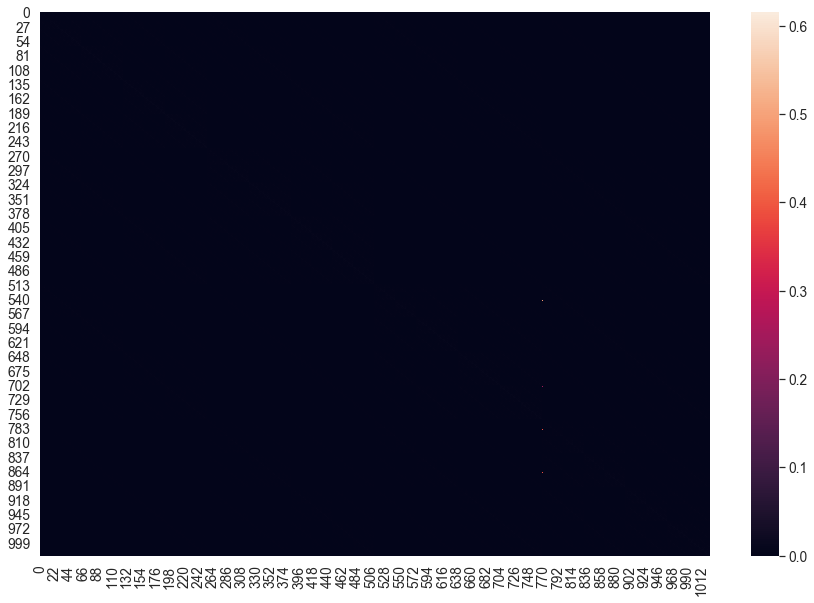

In [4]:

sns.set(style='darkgrid', rc={'figure.figsize':(15,10)}, font_scale=1.25)
cm = az.init_coherence_matrix(number_of_bits,[[3,180,1],[48,200,1],[768,180,1]],5)[2]
sns.heatmap(cm)

## Running embedding

In [ ]:
import analysis as az
import config

config.n2v_num_walks = 30
config.n2v_walk_length = 200
G = create_graph_from_records(record_df)
G.edges.data("weight")
nx.write_edgelist(G,'coherence.edgelist',data=['weight'])
az.create_embedding(ndim=2,p=1.7,q=.9   )
save_experiment(2,record_df)

In [ ]:
import SDNE_impl1 as s1
import analysis as az
from time import time
# The following is from the implementation in SDNE_impl1.py.  Not currently using
G = nx.read_edgelist(az.coh_network_file, nodetype=int, data=(('weight',float),), create_using=nx.DiGraph())
model = s1.SDNE(G,hidden_size=[256,128]) #init model
model.train(batch_size=3000,epochs=1000,verbose=1)# train model
embeddings = model.get_embeddings()# get embedding vectors


# Taken from https://github.com/palash1992/GEM
# embedding = SDNE(d=2, beta=5, alpha=1e-5, nu1=1e-6, nu2=1e-6, K=3, n_units=[50, 15,], n_iter=50, xeta=0.01, n_batch=500,
#                 modelfile=['enc_model.json', 'dec_model.json'],
#                 weightfile=['enc_weights.hdf5', 'dec_weights.hdf5'])
# G = create_graph_from_records(record_df)
# print ('Num nodes: %d, num edges: %d' % (G.number_of_nodes(), G.number_of_edges()))
# t1 = time()
# # Learn embedding - accepts a networkx graph or file with edge list
# Y, t = embedding.learn_embedding(graph=G, edge_f=None, is_weighted=True, no_python=True)
# print (embedding._method_name+':\n\tTraining time: %f' % (time() - t1))






